In [1]:
#importing Libraries
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import time #for FPS control
from datetime import datetime
import re

In [2]:
#import dependencies
%matplotlib inline
import os

DATASET_DIR = "/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Car Number Plates/All/"

data= os.listdir(DATASET_DIR)

# Haar Cascade Detection

In [3]:
plateCascade = cv2.CascadeClassifier("haarcascade_number_plate_recognition.xml")

In [4]:
def plt_show(image, title="", gray = False, size =(100,100)):
    temp = image
    if gray == False:
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        plt.title(title)
        plt.imshow(temp, cmap='gray')
        plt.show()

In [5]:
def detect_number(img):
    temp = img
    gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    number = plateCascade.detectMultiScale(img,1.5,4)
    print("number plate detected:"+str(len(number)))
    for numbers in number:
        (x,y,w,h) = numbers
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+h]
        cv2.rectangle(temp, (x,y), (x+w,y+h), (0,255,0), 3)
        
    #plt_show(temp)

number plate detected:0


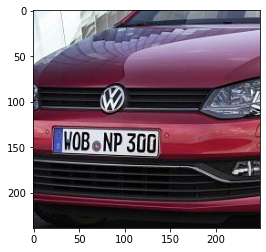

In [6]:
#Take input of car image with number plate
img = cv2.imread("/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Car Number Plates/All/licensed_car231.jpeg")

detect_number(img)
plt_show(img)

In [474]:
import pandas as pd

results = pd.read_csv("/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Results.csv")

In [485]:
results.head(2)

,image_name,Haar_True,Haar_Pred,PScore_Haar,SSD_True,SSD_Pred,PScore_SSD
0,licensed_car0,Yes,Yes,1,Yes,Yes,0.51
1,licensed_car1,Yes,No,0,Yes,Yes,0.47


In [487]:
hy_true = results['Haar_True']
hy_pred = results['Haar_Pred']
hpred_scores = results['PScore_Haar']

In [476]:
# Importing Lib

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

### Accuracy

In [510]:
accuracy_score(hy_true, hy_pred)

0.7171717171717171

### Confusion Matrix

In [477]:
hcm = np.flip(confusion_matrix(hy_true, hy_pred))
print(hcm)

[[111  54]
 [  2  31]]


### Precision & Recall

In [478]:
precision = precision_score(y_true=hy_true, y_pred=hy_pred, average="binary", pos_label='Yes')
print("Precision Value is " + str(precision))

recall = recall_score(y_true=hy_true, y_pred=hy_pred, pos_label='Yes')
print("Recall Value is " + str(recall))

Precision Value is 0.9823008849557522
Recall Value is 0.6727272727272727


When a model has high recall but low precision, then the model classifies most of the positive samples correctly but it has many false positives (i.e. classifies many Negative samples as Positive). When a model has high precision but low recall, then the model is accurate when it classifies a sample as Positive but it may classify only some of the positive samples.

### Classification Report

In [513]:
from sklearn.metrics import classification_report

print(classification_report(hy_true,hy_pred))

              precision    recall  f1-score   support

          No       0.36      0.94      0.53        33
         Yes       0.98      0.67      0.80       165

    accuracy                           0.72       198
   macro avg       0.67      0.81      0.66       198
weighted avg       0.88      0.72      0.75       198



### Precision Recall Curve

In [553]:
# Require to change hy_true to values

hy_true_score = []

for i in hy_true:
    if i == 'Yes':
        hy_true_score.append(1)
    else:
        hy_true_score.append(0)

In [554]:
from sklearn.metrics import precision_recall_curve

In [555]:
hprecision, hrecall, thresholds = precision_recall_curve(hy_true_score, hpred_scores)

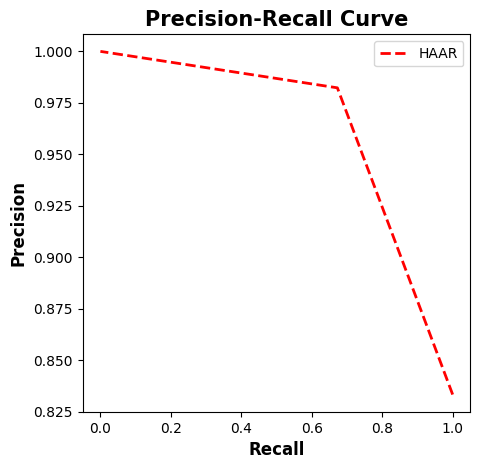

In [561]:
plt.figure(figsize = (5,5), dpi = 100)
plt.plot(hrecall, hprecision, linewidth=2, color="red", label = 'HAAR', linestyle = '--')
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
plt.legend()
plt.show()

The precision-recall curve is shown in the next figure. Note that as the recall increases, the precision decreases. The reason is that when the number of positive samples increases (high recall), the accuracy of classifying each sample correctly decreases (low precision). This is expected, as the model is more likely to fail when there are many samples.

# SSD MobileNet Detection

In [3]:
# SSD Config Files

config_file = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model = 'frozen_inference_graph.pb'

In [4]:
class_labels = []
filename = 'Labels.txt'

with open(filename, 'rt') as fpt:
    class_labels = fpt.read().rstrip('\n').split('\n') #Create All labels in new line
    #class_labels.append(fpt.read())

In [5]:
# Trained Model for CV2

model = cv2.dnn_DetectionModel(frozen_model,config_file)

In [6]:
model.setInputSize(540,540)
model.setInputScale(1.0/127) #255/2---->127 which is gray scale
model.setInputMean((127,127,127)) #mobileNet => [-1,1]
model.setInputSwapRB(True)

<dnn_Model 0000024129BCFBD0>

In [7]:
SSD_Data = "/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Car Number Plates/All/"

import os
s_li = os.listdir(SSD_Data)

In [8]:
#img = cv2.imread("/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Car Number Plates/All/licensed_car0.jpeg")

In [9]:
img = []

for k in range(0,len(s_li)):
    images = cv2.imread('/Users/royku/Sem II Modules/Project Prep/RA/Living Lab Grant/Car Number Plates/All/' + s_li[k])
    img.append(images)

In [26]:
frame = img[197]

In [460]:
class_index, confidence, bbox = model.detect(frame, confThreshold = 0.1)

if (len(class_index)!=0):
    for class_ind, conf, box in zip(class_index.flatten(), confidence.flatten(), bbox):
        if (class_ind<=80):
            if (class_ind-1)==2 or (class_ind-1)==3 or (class_ind-1)==5 or (class_ind-1)==7:
                print(conf, class_labels[class_ind-1])
                cv2.rectangle(frame,box,(225,0,0),2)
                cv2.putText(frame, class_labels[class_ind-1],(box[0]+10,box[1]+40), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(0,255,0),thickness=3)
                cv2.imshow('frame Detection', frame)
                
                ## Conversion ##
                converted = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  #Conversion to gray scale
                filtered = cv2.bilateralFilter(converted, 11, 17, 17) # Reduce Noise / Filtering 
                boundary = cv2.Canny(filtered,30,200) # Detect Edge #(apertureSize = 3, L2gradient = True)

                ## Finding Contours ##
                contour_point  = cv2.findContours(boundary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contour = imutils.grab_contours(contour_point)
                contour = sorted(contour, key=cv2.contourArea, reverse=True)[:20]

                ## Finding Edge Points ##
                edge_points = []
                for con in contour:
                    approx = cv2.approxPolyDP(con, 10, True)
                    if len(approx) == 4:
                        edge_points.append(approx)
                
                (x,y) = np.where(converted == 255)
                (x1, y1) = (np.min(x), np.min(y))
                (x2, y2) = (np.max(x), np.max(y))
                plate= converted[x1:x2+1, y1:y2+1]

                cv2.imshow('Plate Detection', plate)

                if cv2.waitKey(10000) & 0xFF == ord('q'):
                    break

cv2.destroyAllWindows()

0.73802567 motorbike


0, 12, 51, 57, 74, 75, 82, 90, 96, 101, 102, 108, 115, 120, 122, 123, 124, 139, 146, 148, 156, 159, 164, 172, 176, 190

The network can detect small objects and at times fail to detect bigger object. But the pipeline is not able to detect number plates clearly all the time.Often the SSD Network fails to classify cars as car. Often it classifies the same object with 2 diff classes. Higher probability score was achieved for vehicles which had the full back images.

In [529]:
sy_true = results['SSD_True']
sy_pred = results['SSD_Pred']
spred_scores = results['PScore_SSD']

### Accuracy


In [530]:
accuracy_score(sy_true, sy_pred)

0.7070707070707071

### Confusion Matrix

In [532]:
scm = np.flip(confusion_matrix(sy_true, sy_pred))
print(scm)

[[134  32]
 [ 26   6]]


### Precision & Recall

In [533]:
precision = precision_score(y_true=sy_true, y_pred=sy_pred, average="binary", pos_label='Yes')
print("Precision Value is " + str(precision))

recall = recall_score(y_true=sy_true, y_pred=sy_pred, pos_label='Yes')
print("Recall Value is " + str(recall))

Precision Value is 0.8375
Recall Value is 0.8072289156626506


### Classification Report

In [534]:
from sklearn.metrics import classification_report

print(classification_report(sy_true,sy_pred))

              precision    recall  f1-score   support

          No       0.16      0.19      0.17        32
         Yes       0.84      0.81      0.82       166

    accuracy                           0.71       198
   macro avg       0.50      0.50      0.50       198
weighted avg       0.73      0.71      0.72       198



### Precision Recall Curve

In [540]:
# Require to change sy_true to values

sy_true_score = []

for i in hy_true:
    if i == 'Yes':
        sy_true_score.append(1)
    else:
        sy_true_score.append(0)

In [538]:
from sklearn.metrics import precision_recall_curverve

In [541]:
precision, recall, threshol = precision_recall_curve(sy_true_score, spred_scores)

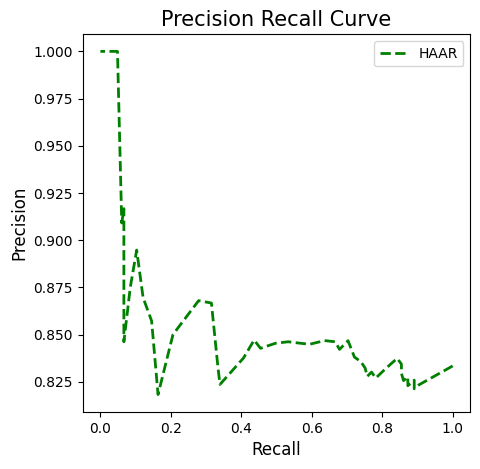

In [562]:
plt.figure(figsize = (5,5), dpi = 100)
plt.plot(recall, precision, linewidth = 2, color = 'green', label = 'HAAR', linestyle = '--')
plt.xlabel("Recall", fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
# Combines Plot

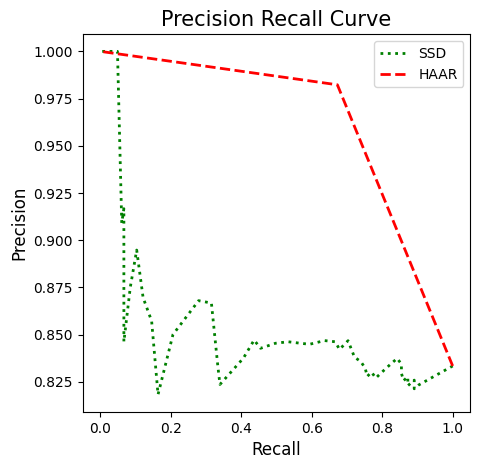

In [551]:
plt.figure(figsize = (5,5), dpi = 100)
plt.plot(recall, precision, linewidth = 2, color = 'green', label = 'SSD', linestyle = ':')
plt.plot(hrecall, hprecision, linewidth = 2, color = 'red', label = 'HAAR', linestyle = '--')
plt.xlabel("Recall", fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize = 15)
plt.legend()
plt.show()